# SCAN Data Auto download script
### Definition:
The goal is to simplify the Project Engineer's procedure for gathering SCAN data for projects and studies

### Inputs:
* Project Coordinates

### Outputs:
* Table of X closest scan sites. Table example below

SCAN SITE 1 | ELEVATION | DISTANCE TO INSTALLATION | SOIL MOISTURE MINIMUM | SOIL TEMP MAXIMUM | AMBIENT TEMP MAXIMUM

SCAN SITE 2 | ELEVATION | DISTANCE TO INSTALLATION | SOIL MOISTURE MINIMUM | SOIL TEMP MAXIMUM | AMBIENT TEMP MAXIMUM

SCAN SITE X | ELEVATION | DISTANCE TO INSTALLATION | SOIL MOISTURE MINIMUM | SOIL TEMP MAXIMUM | AMBIENT TEMP MAXIMUM

In [16]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from math import radians, sin, cos, sqrt, atan2
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [14]:
# Distance Function

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    R = 6371  # Earth radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R * c * 0.621371  # Convert to miles

In [15]:
# API Call functions

def get_station_sensor_data(station_triplet: str) -> Dict[str, pd.DataFrame]:
    """
    Get sensor data for a specific SCAN station and return DataFrames for each element
    Returns a dictionary with 5 DataFrames, one for each sensor element
    """
    DATA_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data"
    
    sensors = {
        'soil_moisture_20': 'SMN:-20',
        'soil_moisture_40': 'SMN:-40',
        'soil_temp_20': 'STX:-20',
        'soil_temp_40': 'STX:-40',
        'air_temp_max': 'TMAX'
    }
    
    sensor_dataframes = {}
    
    # Set date range
    from datetime import datetime, timedelta
    end_date = datetime.now().strftime('%Y-%m-%d')
    begin_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
    
    for sensor_key, element_code in sensors.items():
        encoded_station = station_triplet.replace(':', '%3A')
        
        url = (f"{DATA_URL}?stationTriplets={encoded_station}"
               f"&elements={element_code}"
               f"&duration=DAILY"
               f"&beginDate={begin_date}"
               f"&endDate={end_date}"
               f"&periodRef=END"
               f"&centralTendencyType=NONE"
               f"&returnFlags=false"
               f"&returnOriginalValues=false"
               f"&returnSuspectData=false"
               f"&format=json")
        
        response = requests.get(url, timeout=60)
        
        if response.status_code == 200:
            data = response.json()
            values = data[0]['data'][0]['values']
            
            # Convert to DataFrame and store
            df = pd.DataFrame(values)
            sensor_dataframes[sensor_key] = df
    
    return sensor_dataframes

def get_closest_scan_sites(latitude: float, longitude: float, num_sites: int = 5) -> pd.DataFrame:
    """
    Get the X closest SCAN sites to the given coordinates
    Returns DataFrame with station info only (no sensor data)
    """
    STATIONS_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/stations"
    
    df_columns = [
        'SCAN Site',
        'Station Triplet', 
        'Elevation', 
        'Distance to Installation',
        'Latitude',
        'Longitude'
    ]
    
    try:
        # Get ALL stations first
        params = {'format': 'json'}
        
        response = requests.get(STATIONS_URL, params=params, timeout=60)
        response.raise_for_status()
        
        all_stations = response.json()
        
        # Convert to pandas DataFrame
        df_all = pd.DataFrame(all_stations)
        
        # Filter for SCAN stations
        df_scan = df_all[df_all['networkCode'] == 'SCAN'].copy()
        
        if len(df_scan) == 0:
            return pd.DataFrame(columns=df_columns)
        
        # Calculate distances
        distances = []
        for _, station in df_scan.iterrows():
            try:
                station_lat = station.get('latitude', 0)
                station_lon = station.get('longitude', 0)
                
                if station_lat and station_lon:
                    distance = haversine_distance(latitude, longitude, station_lat, station_lon)
                    distances.append(distance)
                else:
                    distances.append(float('inf'))
            except:
                distances.append(float('inf'))
        
        df_scan['Distance to Installation'] = distances
        
        # Remove stations with invalid distances and sort
        df_scan = df_scan[df_scan['Distance to Installation'] != float('inf')]
        df_scan = df_scan.sort_values('Distance to Installation').head(num_sites)
        
        # Create final DataFrame with station info only
        result_df = pd.DataFrame({
            'SCAN Site': df_scan['name'].values,
            'Station Triplet': df_scan['stationTriplet'].values,
            'Elevation': df_scan['elevation'].apply(lambda x: f"{x} ft" if pd.notna(x) else 'N/A'),
            'Distance to Installation': df_scan['Distance to Installation'].round(2),
            'Latitude': df_scan['latitude'].values,
            'Longitude': df_scan['longitude'].values
        })
        
        return result_df.reset_index(drop=True)
        
    except requests.RequestException as e:
        print(f"Error fetching stations data: {e}")
        return pd.DataFrame(columns=df_columns)

def get_scan_sites_within_radius_df(latitude: float, longitude: float, radius_miles: float = 50) -> pd.DataFrame:
    """
    Get all SCAN sites within a specified radius as a DataFrame
    Returns DataFrame with station info only (no sensor data)
    """
    STATIONS_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/stations"
    
    df_columns = [
        'SCAN Site',
        'Station Triplet',
        'Elevation', 
        'Distance to Installation',
        'Latitude',
        'Longitude'
    ]
    
    try:
        params = {'format': 'json'}
        
        response = requests.get(STATIONS_URL, params=params, timeout=60)
        all_stations = response.json()
        
        # Convert to DataFrame and filter
        df_all = pd.DataFrame(all_stations)
        df_scan = df_all[df_all['networkCode'] == 'SCAN'].copy()
        
        # Calculate distances
        distances = []
        for _, station in df_scan.iterrows():
            try:
                station_lat = station.get('latitude', 0)
                station_lon = station.get('longitude', 0)
                
                if station_lat and station_lon:
                    distance = haversine_distance(latitude, longitude, station_lat, station_lon)
                    distances.append(distance)
                else:
                    distances.append(float('inf'))
            except:
                distances.append(float('inf'))
        
        df_scan['Distance to Installation'] = distances
        
        # Filter by radius
        df_in_radius = df_scan[df_scan['Distance to Installation'] <= radius_miles].copy()
        df_in_radius = df_in_radius.sort_values('Distance to Installation')
        
        # Create final DataFrame
        result_df = pd.DataFrame({
            'SCAN Site': df_in_radius['name'].values,
            'Station Triplet': df_in_radius['stationTriplet'].values,
            'Elevation': df_in_radius['elevation'].apply(lambda x: f"{x} ft" if pd.notna(x) else 'N/A'),
            'Distance to Installation': df_in_radius['Distance to Installation'].round(2),
            'Latitude': df_in_radius['latitude'].values,
            'Longitude': df_in_radius['longitude'].values
        })
        
        return result_df.reset_index(drop=True)
        
    except requests.RequestException as e:
        print(f"Error fetching stations data: {e}")
        return pd.DataFrame(columns=df_columns)

In [17]:
# Plotting Functions 

def plot_soil_moisture(soil_moisture_20_df, soil_moisture_40_df, station_name):
    """
    Plot soil moisture data for both -20 and -40 depths
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convert date strings to datetime
    soil_moisture_20_df['date'] = pd.to_datetime(soil_moisture_20_df['date'])
    soil_moisture_40_df['date'] = pd.to_datetime(soil_moisture_40_df['date'])
    
    # Convert values to numeric and remove outliers
    values_20 = pd.to_numeric(soil_moisture_20_df['value'], errors='coerce').dropna()
    values_40 = pd.to_numeric(soil_moisture_40_df['value'], errors='coerce').dropna()
    
    # Remove outliers using IQR
    def remove_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series >= lower_bound) & (series <= upper_bound)]
    
    clean_20 = remove_outliers(values_20)
    clean_40 = remove_outliers(values_40)
    
    # Calculate minimum values
    min_20 = clean_20.min() if not clean_20.empty else None
    min_40 = clean_40.min() if not clean_40.empty else None
    
    # Plot the data
    ax.plot(soil_moisture_20_df['date'], values_20, 'b-', linewidth=1, alpha=0.7, label='Soil Moisture -20"')
    ax.plot(soil_moisture_40_df['date'], values_40, 'r-', linewidth=1, alpha=0.7, label='Soil Moisture -40"')
    
    # Add minimum value callouts
    if min_20 is not None:
        min_date_20 = soil_moisture_20_df.loc[values_20.idxmin(), 'date']
        ax.annotate(f'Min: {min_20:.1f}%', 
                   xy=(min_date_20, min_20), 
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='blue'))
    
    if min_40 is not None:
        min_date_40 = soil_moisture_40_df.loc[values_40.idxmin(), 'date']
        ax.annotate(f'Min: {min_40:.1f}%', 
                   xy=(min_date_40, min_40), 
                   xytext=(10, -20), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='red'))
    
    # Formatting
    ax.set_title(f'{station_name} - Soil Moisture Percent Minimum', fontsize=14, fontweight='bold')
    ax.set_ylabel('Soil Moisture (%)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    return fig

def plot_soil_temp(soil_temp_20_df, soil_temp_40_df, station_name):
    """
    Plot soil temperature data for both -20 and -40 depths
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convert date strings to datetime
    soil_temp_20_df['date'] = pd.to_datetime(soil_temp_20_df['date'])
    soil_temp_40_df['date'] = pd.to_datetime(soil_temp_40_df['date'])
    
    # Convert values to numeric and remove outliers
    values_20 = pd.to_numeric(soil_temp_20_df['value'], errors='coerce').dropna()
    values_40 = pd.to_numeric(soil_temp_40_df['value'], errors='coerce').dropna()
    
    # Remove outliers using IQR
    def remove_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series >= lower_bound) & (series <= upper_bound)]
    
    clean_20 = remove_outliers(values_20)
    clean_40 = remove_outliers(values_40)
    
    # Calculate maximum values
    max_20 = clean_20.max() if not clean_20.empty else None
    max_40 = clean_40.max() if not clean_40.empty else None
    
    # Plot the data
    ax.plot(soil_temp_20_df['date'], values_20, 'b-', linewidth=1, alpha=0.7, label='Soil Temp -20"')
    ax.plot(soil_temp_40_df['date'], values_40, 'r-', linewidth=1, alpha=0.7, label='Soil Temp -40"')
    
    # Add maximum value callouts
    if max_20 is not None:
        max_date_20 = soil_temp_20_df.loc[values_20.idxmax(), 'date']
        ax.annotate(f'Max: {max_20:.1f}°F', 
                   xy=(max_date_20, max_20), 
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='blue'))
    
    if max_40 is not None:
        max_date_40 = soil_temp_40_df.loc[values_40.idxmax(), 'date']
        ax.annotate(f'Max: {max_40:.1f}°F', 
                   xy=(max_date_40, max_40), 
                   xytext=(10, -20), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='red'))
    
    # Formatting
    ax.set_title(f'{station_name} - Soil Temperature Maximum', fontsize=14, fontweight='bold')
    ax.set_ylabel('Soil Temperature (°F)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    return fig

def plot_ambient_temp(air_temp_max_df, station_name):
    """
    Plot ambient air temperature data
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convert date strings to datetime
    air_temp_max_df['date'] = pd.to_datetime(air_temp_max_df['date'])
    
    # Convert values to numeric and remove outliers
    values = pd.to_numeric(air_temp_max_df['value'], errors='coerce').dropna()
    
    # Remove outliers using IQR
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    clean_values = values[(values >= lower_bound) & (values <= upper_bound)]
    
    # Calculate maximum value
    max_temp = clean_values.max() if not clean_values.empty else None
    
    # Plot the data
    ax.plot(air_temp_max_df['date'], values, 'b-', linewidth=1, alpha=0.7, label='Air Temperature Max')
    
    # Add maximum value callout
    if max_temp is not None:
        max_date = air_temp_max_df.loc[values.idxmax(), 'date']
        ax.annotate(f'Max: {max_temp:.1f}°F', 
                   xy=(max_date, max_temp), 
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='blue'))
    
    # Formatting
    ax.set_title(f'{station_name} - Ambient Air Temperature Maximum', fontsize=14, fontweight='bold')
    ax.set_ylabel('Air Temperature (°F)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    return fig

In [20]:
# Overview Function and remove_outliers helper

def remove_outliers(series):
    """
    Helper function to remove outliers using IQR method
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    filtered_values = series[(series >= lower_bound) & (series <= upper_bound)]
    
    # Use filtered values if we have enough data, otherwise use original
    if len(filtered_values) >= len(series) * 0.5:
        return filtered_values
    else:
        return series
        
def create_station_overview(nearby_stations_df):
    """
    Create an overview DataFrame with sensor data summary for nearby stations
    """
    overview_data = []
    
    for _, station in nearby_stations_df.iterrows():
        station_triplet = station['Station Triplet']
        station_name = station['SCAN Site']
        
        # Get sensor data for this station
        sensor_dfs = get_station_sensor_data(station_triplet)
        
        # Process each sensor type to get min/max values
        soil_moisture_min_20 = 'N/A'
        soil_moisture_min_40 = 'N/A'
        soil_temp_max_20 = 'N/A'
        soil_temp_max_40 = 'N/A'
        ambient_temp_max = 'N/A'
        
        # Process soil moisture -20
        if 'soil_moisture_20' in sensor_dfs and not sensor_dfs['soil_moisture_20'].empty:
            df = sensor_dfs['soil_moisture_20']
            values = pd.to_numeric(df['value'], errors='coerce').dropna()
            if not values.empty:
                clean_values = remove_outliers(values)
                soil_moisture_min_20 = f"{clean_values.min():.1f}%" if not clean_values.empty else 'N/A'
        
        # Process soil moisture -40
        if 'soil_moisture_40' in sensor_dfs and not sensor_dfs['soil_moisture_40'].empty:
            df = sensor_dfs['soil_moisture_40']
            values = pd.to_numeric(df['value'], errors='coerce').dropna()
            if not values.empty:
                clean_values = remove_outliers(values)
                soil_moisture_min_40 = f"{clean_values.min():.1f}%" if not clean_values.empty else 'N/A'
        
        # Process soil temp -20
        if 'soil_temp_20' in sensor_dfs and not sensor_dfs['soil_temp_20'].empty:
            df = sensor_dfs['soil_temp_20']
            values = pd.to_numeric(df['value'], errors='coerce').dropna()
            if not values.empty:
                clean_values = remove_outliers(values)
                soil_temp_max_20 = f"{clean_values.max():.1f}°F" if not clean_values.empty else 'N/A'
        
        # Process soil temp -40
        if 'soil_temp_40' in sensor_dfs and not sensor_dfs['soil_temp_40'].empty:
            df = sensor_dfs['soil_temp_40']
            values = pd.to_numeric(df['value'], errors='coerce').dropna()
            if not values.empty:
                clean_values = remove_outliers(values)
                soil_temp_max_40 = f"{clean_values.max():.1f}°F" if not clean_values.empty else 'N/A'
        
        # Process ambient temp
        if 'air_temp_max' in sensor_dfs and not sensor_dfs['air_temp_max'].empty:
            df = sensor_dfs['air_temp_max']
            values = pd.to_numeric(df['value'], errors='coerce').dropna()
            if not values.empty:
                clean_values = remove_outliers(values)
                ambient_temp_max = f"{clean_values.max():.1f}°F" if not clean_values.empty else 'N/A'
        
        # Combine soil moisture from both depths (take the minimum of both)
        if soil_moisture_min_20 != 'N/A' and soil_moisture_min_40 != 'N/A':
            min_20_val = float(soil_moisture_min_20.replace('%', ''))
            min_40_val = float(soil_moisture_min_40.replace('%', ''))
            soil_moisture_min = f"{min(min_20_val, min_40_val):.1f}%"
        elif soil_moisture_min_20 != 'N/A':
            soil_moisture_min = soil_moisture_min_20
        elif soil_moisture_min_40 != 'N/A':
            soil_moisture_min = soil_moisture_min_40
        else:
            soil_moisture_min = 'N/A'
        
        overview_data.append({
            'SCAN Site': station_name,
            'Elevation': station['Elevation'],
            'Distance to Installation': station['Distance to Installation'],
            'Soil Moisture Minimum': soil_moisture_min,
            'Soil Temp Maximum 20in': soil_temp_max_20,
            'Soil Temp Maximum 40in': soil_temp_max_40,
            'Ambient Temp Maximum': ambient_temp_max
        })
    
    # Create DataFrame
    overview_df = pd.DataFrame(overview_data)
    
    return overview_df

In [5]:
# Get nearby stations
nearby_stations = get_closest_scan_sites(45.6790, -111.0426, 3)

# Get sensor data for a specific station
station_triplet = nearby_stations['Station Triplet'].iloc[0]
sensor_dfs = get_station_sensor_data(station_triplet)

# Access individual sensor DataFrames
soil_moisture_20_df = sensor_dfs['soil_moisture_20']
soil_moisture_40_df = sensor_dfs['soil_moisture_40']
soil_temp_20_df = sensor_dfs['soil_temp_20']
soil_temp_40_df = sensor_dfs['soil_temp_40']
air_temp_max_df = sensor_dfs['air_temp_max']


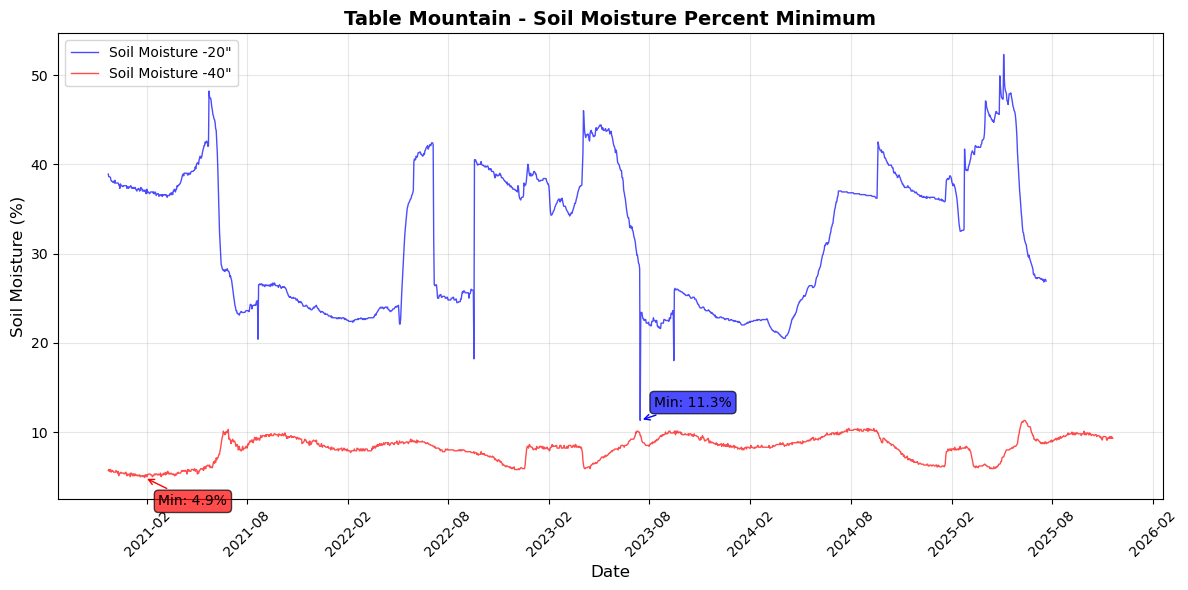

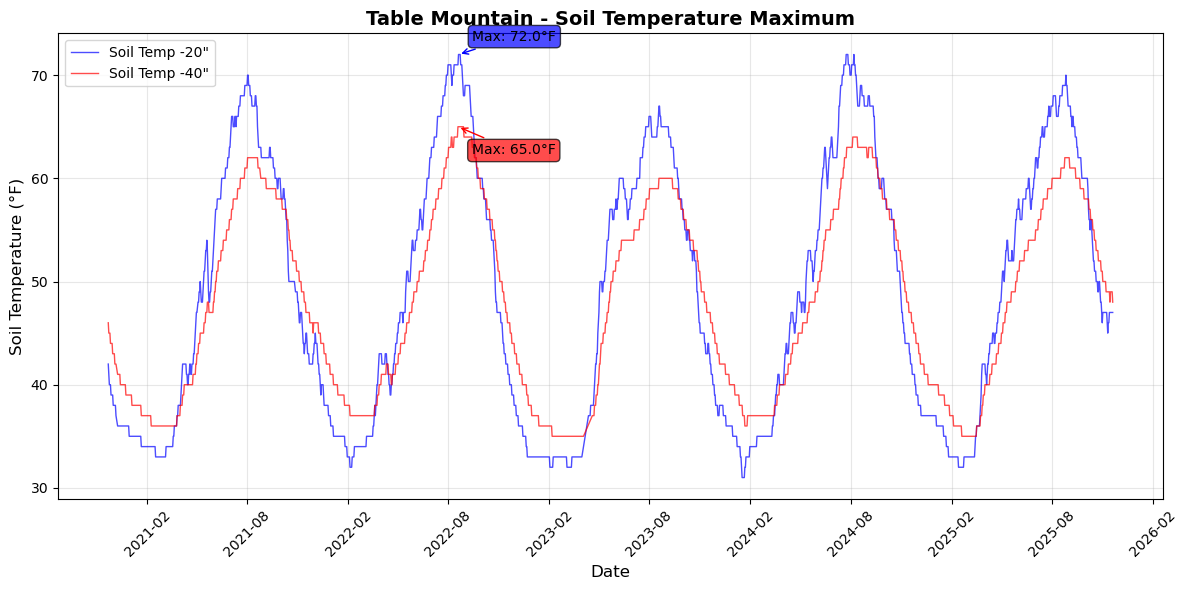

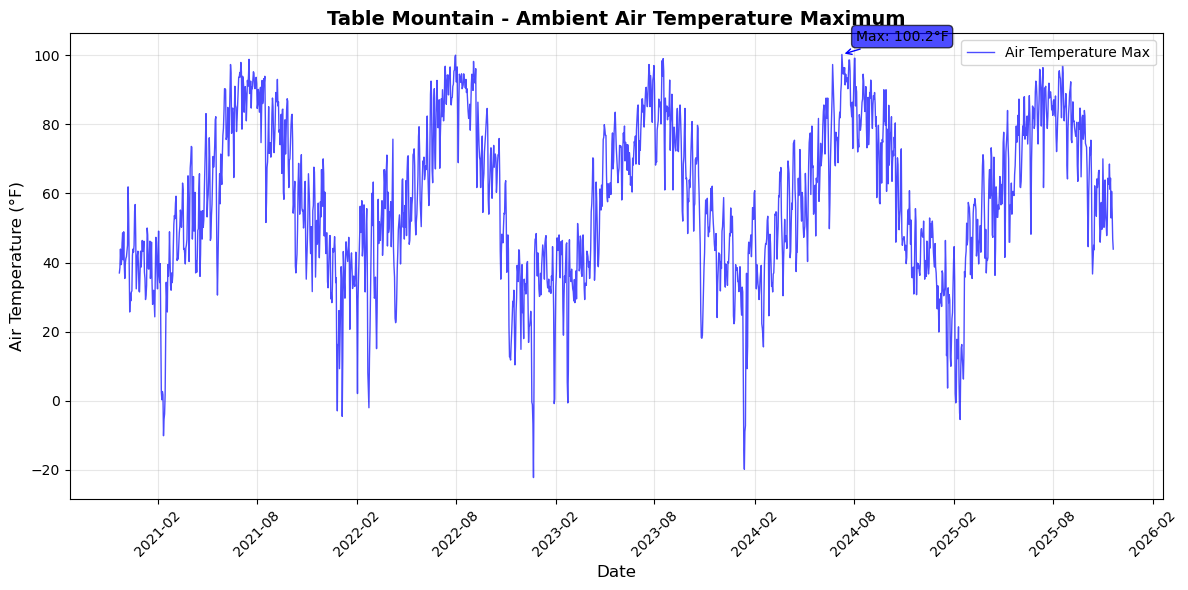

In [18]:
# Get sensor data for a station
station_triplet = nearby_stations['Station Triplet'].iloc[0]
station_name = nearby_stations['SCAN Site'].iloc[0]
sensor_dfs = get_station_sensor_data(station_triplet)

# Create plots
soil_moisture_plot = plot_soil_moisture(
    sensor_dfs['soil_moisture_20'], 
    sensor_dfs['soil_moisture_40'], 
    station_name
)

soil_temp_plot = plot_soil_temp(
    sensor_dfs['soil_temp_20'], 
    sensor_dfs['soil_temp_40'], 
    station_name
)

ambient_temp_plot = plot_ambient_temp(
    sensor_dfs['air_temp_max'], 
    station_name
)

# Show plots
plt.show()

In [21]:
# Get nearby stations
nearby_stations = get_closest_scan_sites(45.6790, -111.0426, 5)

# Create overview table
overview_table = create_station_overview(nearby_stations)

# Display the table
overview_table

,SCAN Site,Elevation,Distance to Installation,Soil Moisture Minimum,Soil Temp Maximum 20in,Soil Temp Maximum 40in,Ambient Temp Maximum
0,Table Mountain,4470.0 ft,27.59,4.9%,72.0°F,65.0°F,100.2°F
1,Moccasin,4250.0 ft,108.58,7.3%,69.0°F,65.0°F,99.7°F
2,Conrad Ag Rc,3700.0 ft,186.09,21.2%,72.0°F,68.0°F,100.4°F
3,Violett,3210.0 ft,190.59,3.4%,76.0°F,69.0°F,104.5°F
4,Fort Assiniboine #1,2710.0 ft,202.87,14.3%,69.0°F,64.0°F,106.0°F
